In [50]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import random
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn import datasets 
import pandas as pd
import seaborn as sns

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class K_MEANS:
    '''
    Divides given data into K clusters.
    
    Fields:
        df: Dataset without 'target' attribute
        N: Size of dataset
        k: Number of clusters
        MAX_ITER: Number of iterations
        labels: Class of each sample
        centroids: N x 2 array with coordinates of centroids
        distances: N x N matrix of distances, where len(df) = N
    '''
    
    def __init__(self, data, k = 3, MAX_ITER = 100):
        self.df = np.array(data)
        (self.N, self.M) = self.df.shape
        self.k = k;
        self.MAX_ITER = MAX_ITER
        self.iterations = 0
        self.labels = np.zeros(self.N, dtype=np.int)
        self.centroids = self.random_centroids()
        self.distances = self.compute_distances()
       
        
    def random_centroids(self):
        '''
        Returns:
            List of random k indices
        '''
        centrs = random.sample(range(self.N), self.k)
        return self.df[centrs]
    
    
    def compute_distances(self):
        '''
        Returns: 
            N x N matrix of distances
        '''
        X, Y = self.df, self.centroids
        dists = -2 * np.dot(X, Y.T) + np.sum(Y ** 2, axis=1)
        return dists
        
    
    def assign_centroids(self):
        '''
        Find closest centroid for each data sample
        
        Returns:
            True: Found new centroids
            False: Centroids are the same
        '''
        self.distances = self.compute_distances()
        nearest_centroids = np.argmin(self.distances, axis=1)
        
        if abs(np.sum(nearest_centroids - self.labels)) < 1e-100:
            return False
        
        self.labels = nearest_centroids
        return True
    
    
    def update_centroids(self):
        '''
        Determine new centroids by taking the average of all the points assigned to that cluster.
        '''
        new_centroids = np.zeros(self.k * self.M).reshape(self.k, self.M)
        centroid_cnt = np.full(self.k, 1e-100)
        for i in range(self.k):
            assigned_to_ith = self.labels == i
            new_centroids[i] += np.sum(self.df[assigned_to_ith], axis=0)
            centroid_cnt[i] += len(self.df[assigned_to_ith])
            
        self.centroids = new_centroids / centroid_cnt[:, np.newaxis]
        
    
    def RUN(self, show_images=False):
        '''
        Runs KMEANS algorithms as long as we can update centroids or till we reach MAX_ITER
        
        Parameters:
            show_images: True / False - either shows or does not show images
                         For a integer 'i' shows every ith image 
        '''
        for no in tqdm.tqdm(range(self.MAX_ITER)):
            self.iterations = no
            if not self.assign_centroids():
                if show_images:
                    self.plot_2d()
                break
            
            if show_images and no % show_images == 0:
                self.plot_2d()
                
            self.update_centroids()
    
    def plot_2d(self):
        plt.figure(dpi=100)
        plt.title(f'Iterations: {self.iterations}')
        plt.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), edgecolor='red', s=100, alpha=0.8)
        plt.show()
        
        
    def plot_before_and_after_2d(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(20,5)
        ax1.scatter(self.df[:, 0], self.df[:, 1], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), edgecolor='red', s=100, alpha=0.8)
        
        
    def plot_before_and_after_3d(self):
        fig = plt.figure(figsize=(20, 8))
        # 121 - 1 x 2 grid 1st subplot
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        ax1.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], self.centroids[:, 2],  c=range(self.k), edgecolor='red', s=100, alpha=0.8)
    

# Zadanie 1. (1 punkt)
Napisz program, który generuje zbiór N = 5000 losowych wektorów danych z mieszaniny </br>
rozkładów gaussowskich o niżej podanych parametrach i sprawdź działanie algorytmu K-Means na tym zbiorze. </br>
**a) d = 2, K = 5, p = 1/K * 1, µk = 3k * 1, Σk = I (dla k = 1, 2, …, K), </br>
b) jak w a), oprócz Σ3 = [3 0; 0 1], </br>
c) jak w b), oprócz Σ1 = [3 1; 1 1], </br>
d) jak w c), oprócz p = [0.2; 0.1; 0.3; 0.1; 0.3], </br>
e) jak w a), oprócz d = 3 i Σ3 = [3 1 0; 1 1 0; 0 0 1], </br>
f) jak w a), oprócz d = 100 i K = 10.** </br>
(1 to wektor odpowiedniej długości złożony z samych jedynek, I to macierz identycznościowa). </br>
Jak pogrupowałbyś te dane, jeśli nie znałbyś wartości K użytej w generatorze?  </br>


In [91]:
def generate(N, d, K, p_vec, Mu, Sigma):
    '''
    Generates 'N' vectors of size 'd' from N(mu_i, sigma_i).
    
    Parameters:
        N: Number of vectors
        K: Number or d-dimensionals Gaussian distributions
        d: Dimensions
        p_vec: Vector of p_i: p_i, where p_i is pbb. of chosing ith distribution
        Mu: Vector of mu_i, where mu_i belongs to ith distribution
        Sigma: Vector of matrices Σ_i 
        
    Returns:
        Result: N x d matrix and targets
    '''
    
    assert((np.sum(p_vec) - 1) < 1e-10)
    assert(len(p_vec) == K and len(Mu) == K)
 
    # Draw N distributions with pbbs
    distributions_ids = random.choices(range(K), k=N, weights=p_vec)
 
    # Sample N vectors
    # We could use 'np.random.multivariate_normal(mean, cov, N).T'
    # But let's do a Cholesky decomposition
    
    Result = np.random.randn(N, d)
    L = np.linalg.cholesky(Sigma)
    
    for i in tqdm.tqdm(range(N)):
        Result[i, :] = Mu[distributions_ids[i], :] + np.dot(L[distributions_ids[i], :, :], Result[i, :])
    

    return np.array(Result)
        


100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 416688.59it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


Iterations: 10


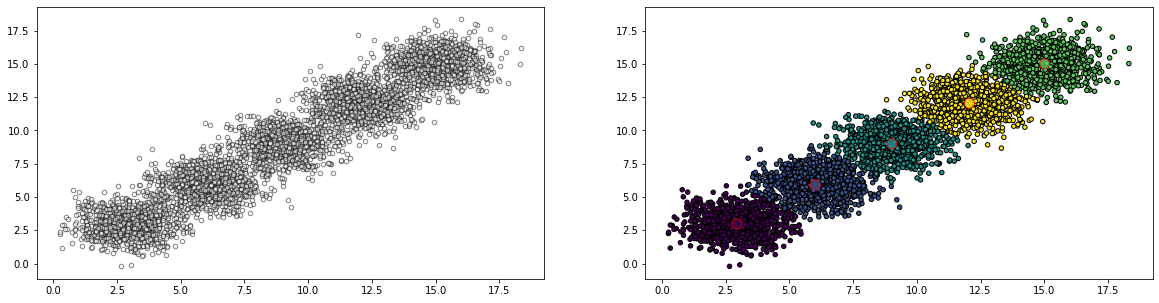

In [92]:
# a)
N, d, K = 5000, 2, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')


100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 358126.33it/s]

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


Iterations: 20


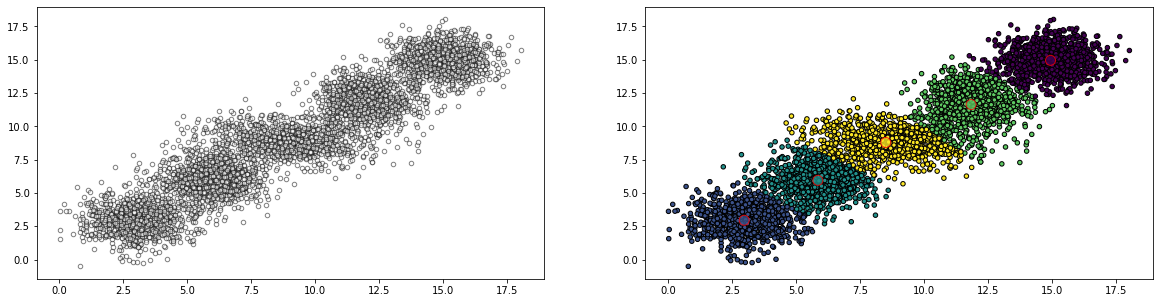

In [93]:
# b)
N, d, K = 5000, 2, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[2] = np.array([[3, 0], [0, 1]])
L = np.linalg.cholesky(Sigma[2])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


Iterations: 50


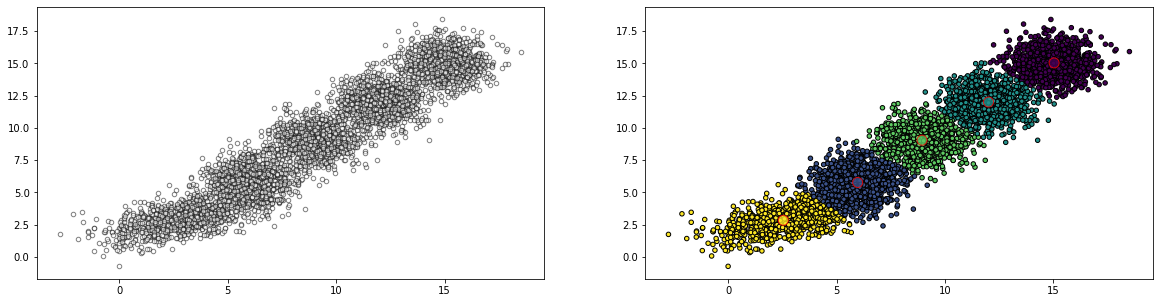

In [6]:
# c)
N, d, K = 5000, 2, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[0] = np.array([[3, 1], [1, 1]])
L = np.linalg.cholesky(Sigma[2])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


Iterations: 21


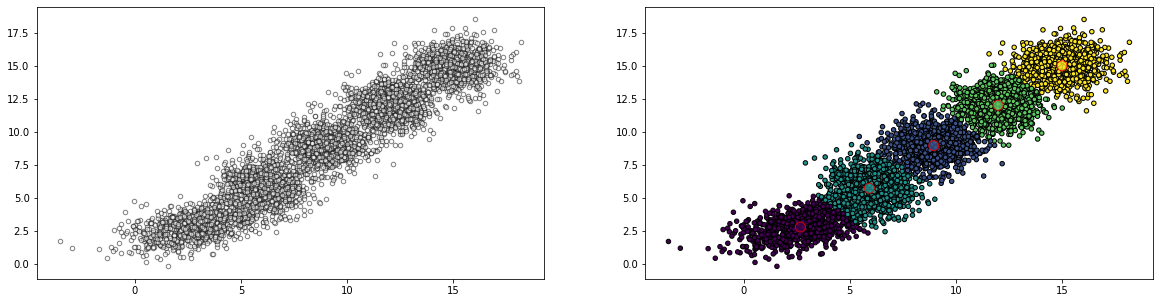

In [7]:
# d
N, d, K = 5000, 2, 5
p_vec = np.array([0.2, 0.1, 0.3, 0.1, 0.3])
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[0] = np.array([[3, 1], [1, 1]])
L = np.linalg.cholesky(Sigma[2])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


Iterations: 11
Wall time: 61.2 ms


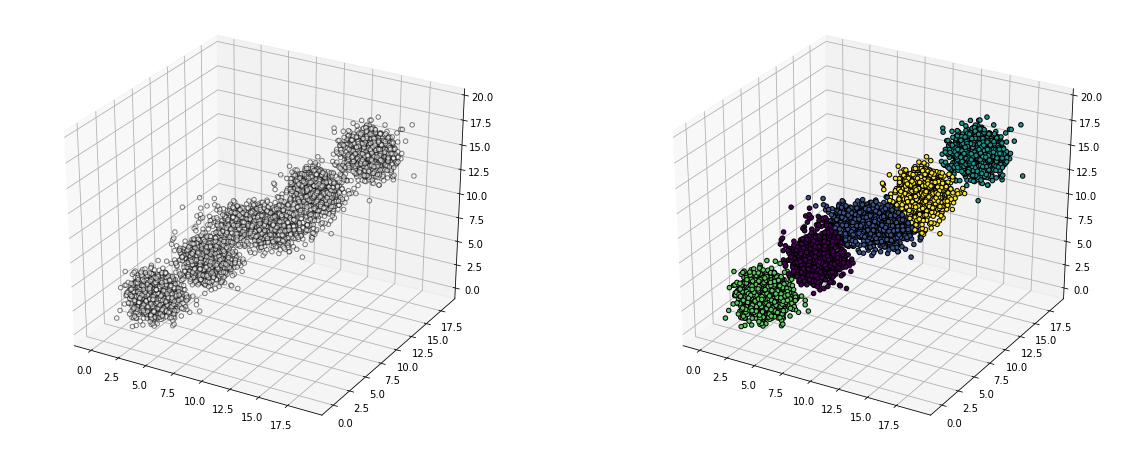

In [8]:
%%time
# e)
N, d, K = 5000, 3, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[2] = np.array([[3, 1, 0], [1, 1, 0], [0, 0, 1]])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]


Iterations: 2
Wall time: 293 ms


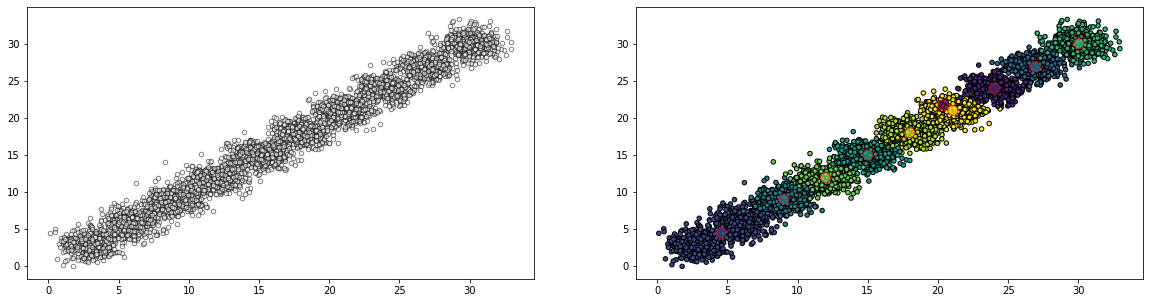

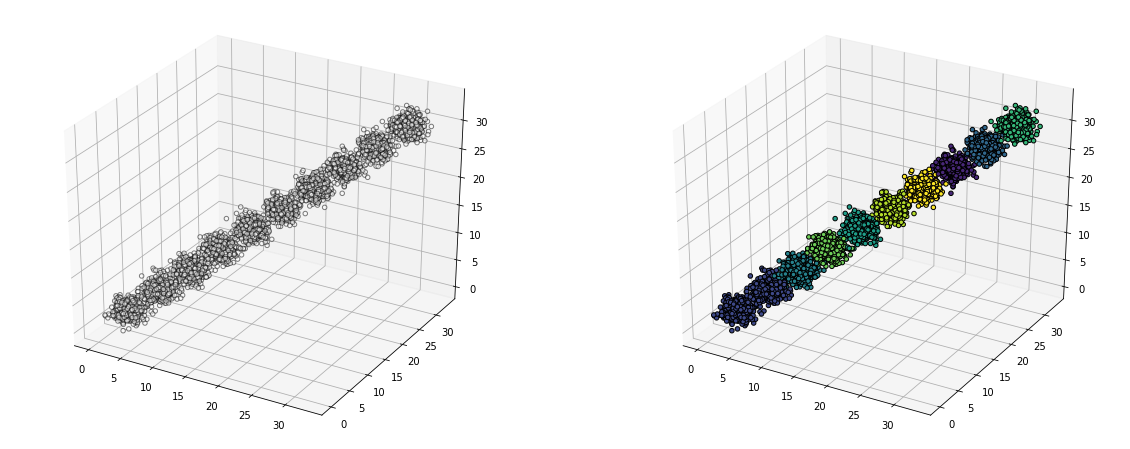

In [9]:
%%time
# f)
N, d, K = 5000, 100, 10
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=200)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')

# Zadanie 2. (1 punkt)
Wygeneruj zbiór N = 1000000 losowych danych z d = 1000 wymiarowej mieszaniny K = 1000 <br/>
rozkładów gaussowskich takiej, że odległość między środkami µk każdych dwóch rozkładów tej <br/>
mieszaniny jest nie mniejsza niż q = 10. Prawdopodobieństwa wyboru rozkładów mogą być równe, <br/>
p = 1/K * 1, a same rozkłady mogą mieć nieskorelowane zmienne, Σk = I. Sprawdź działanie <br/>
algorytmu K-Means na tym zbiorze. Poeksperymentuj z innymi wartościami parametru q. <br/>


  4%|███▋                                                                              | 9/200 [00:15<05:27,  1.72s/it]

Iterations: 9
Wall time: 23.1 s


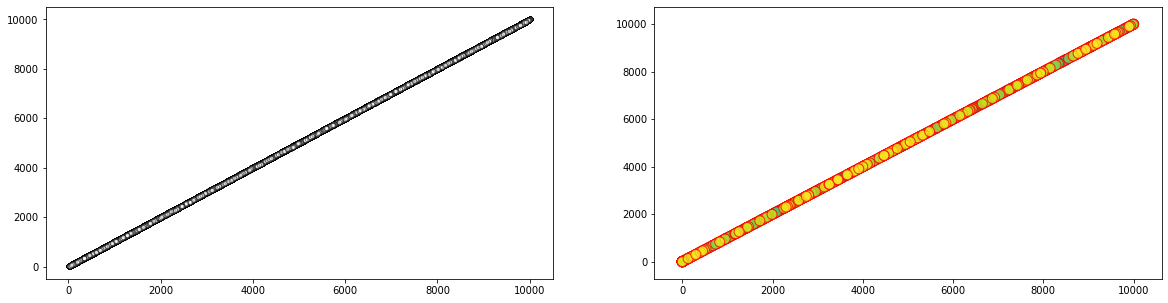

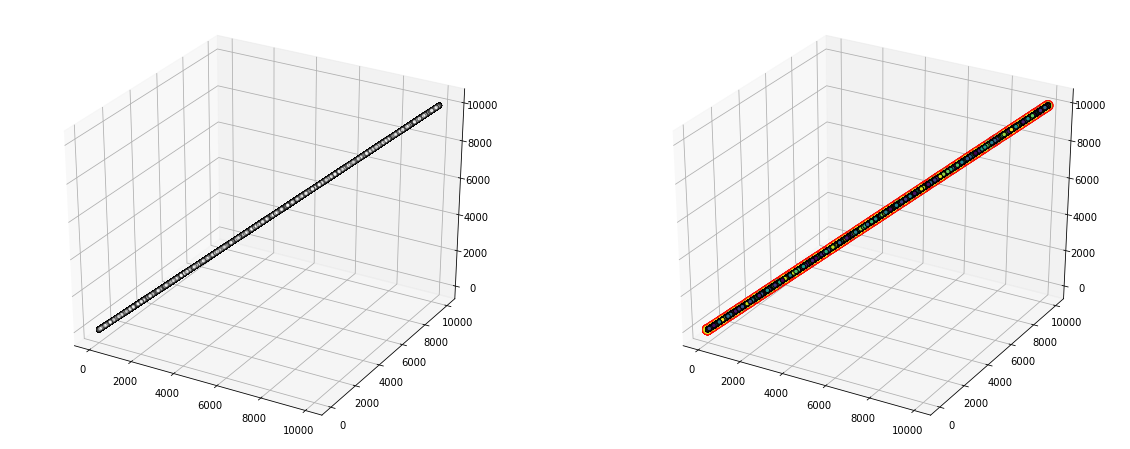

In [4]:
%%time
N, d, K = 100000, 100, 1000
p_vec = np.ones(K) / K
q = 10
Mu = q * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=200)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')

In [ ]:
%%time
N, d, K = 1000000, 100, 1000
p_vec = np.ones(K) / K
q = 10
Mu = q * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=200)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')

# Zadanie 3. (2 punkty)
W UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/) można znaleźć przykładowe <br/>
dane do testowania działania algorytmów eksploracji danych. Pobierz 5 zestawów danych <br/>
(Iris, Wine oraz 3 inne wybrane przez siebie). Zapoznaj się z opisem tych danych. <br/>
Spróbuj opisać charakterystykę tych danych. Spróbuj przedstawić te dane na wykresach. <br/>
Sprawdź jak dobrze można je pogrupować za pomocą znanych Ci algorytmów grupowania (sprawdź co najmniej KMeans). <br/>


### 1. Wine dataset

In [51]:
wine = datasets.load_wine()
wine_df = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                       columns=wine['feature_names'] + ['target'])

targets = wine_df['target']
wine_df = wine_df[wine['feature_names']]
wine_df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                          3.92   1065.0  
1                          3.40   1050.0  
2                          3.17   1185.0  
3                          3.45   1480.0  
4                          2.93    735.0


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


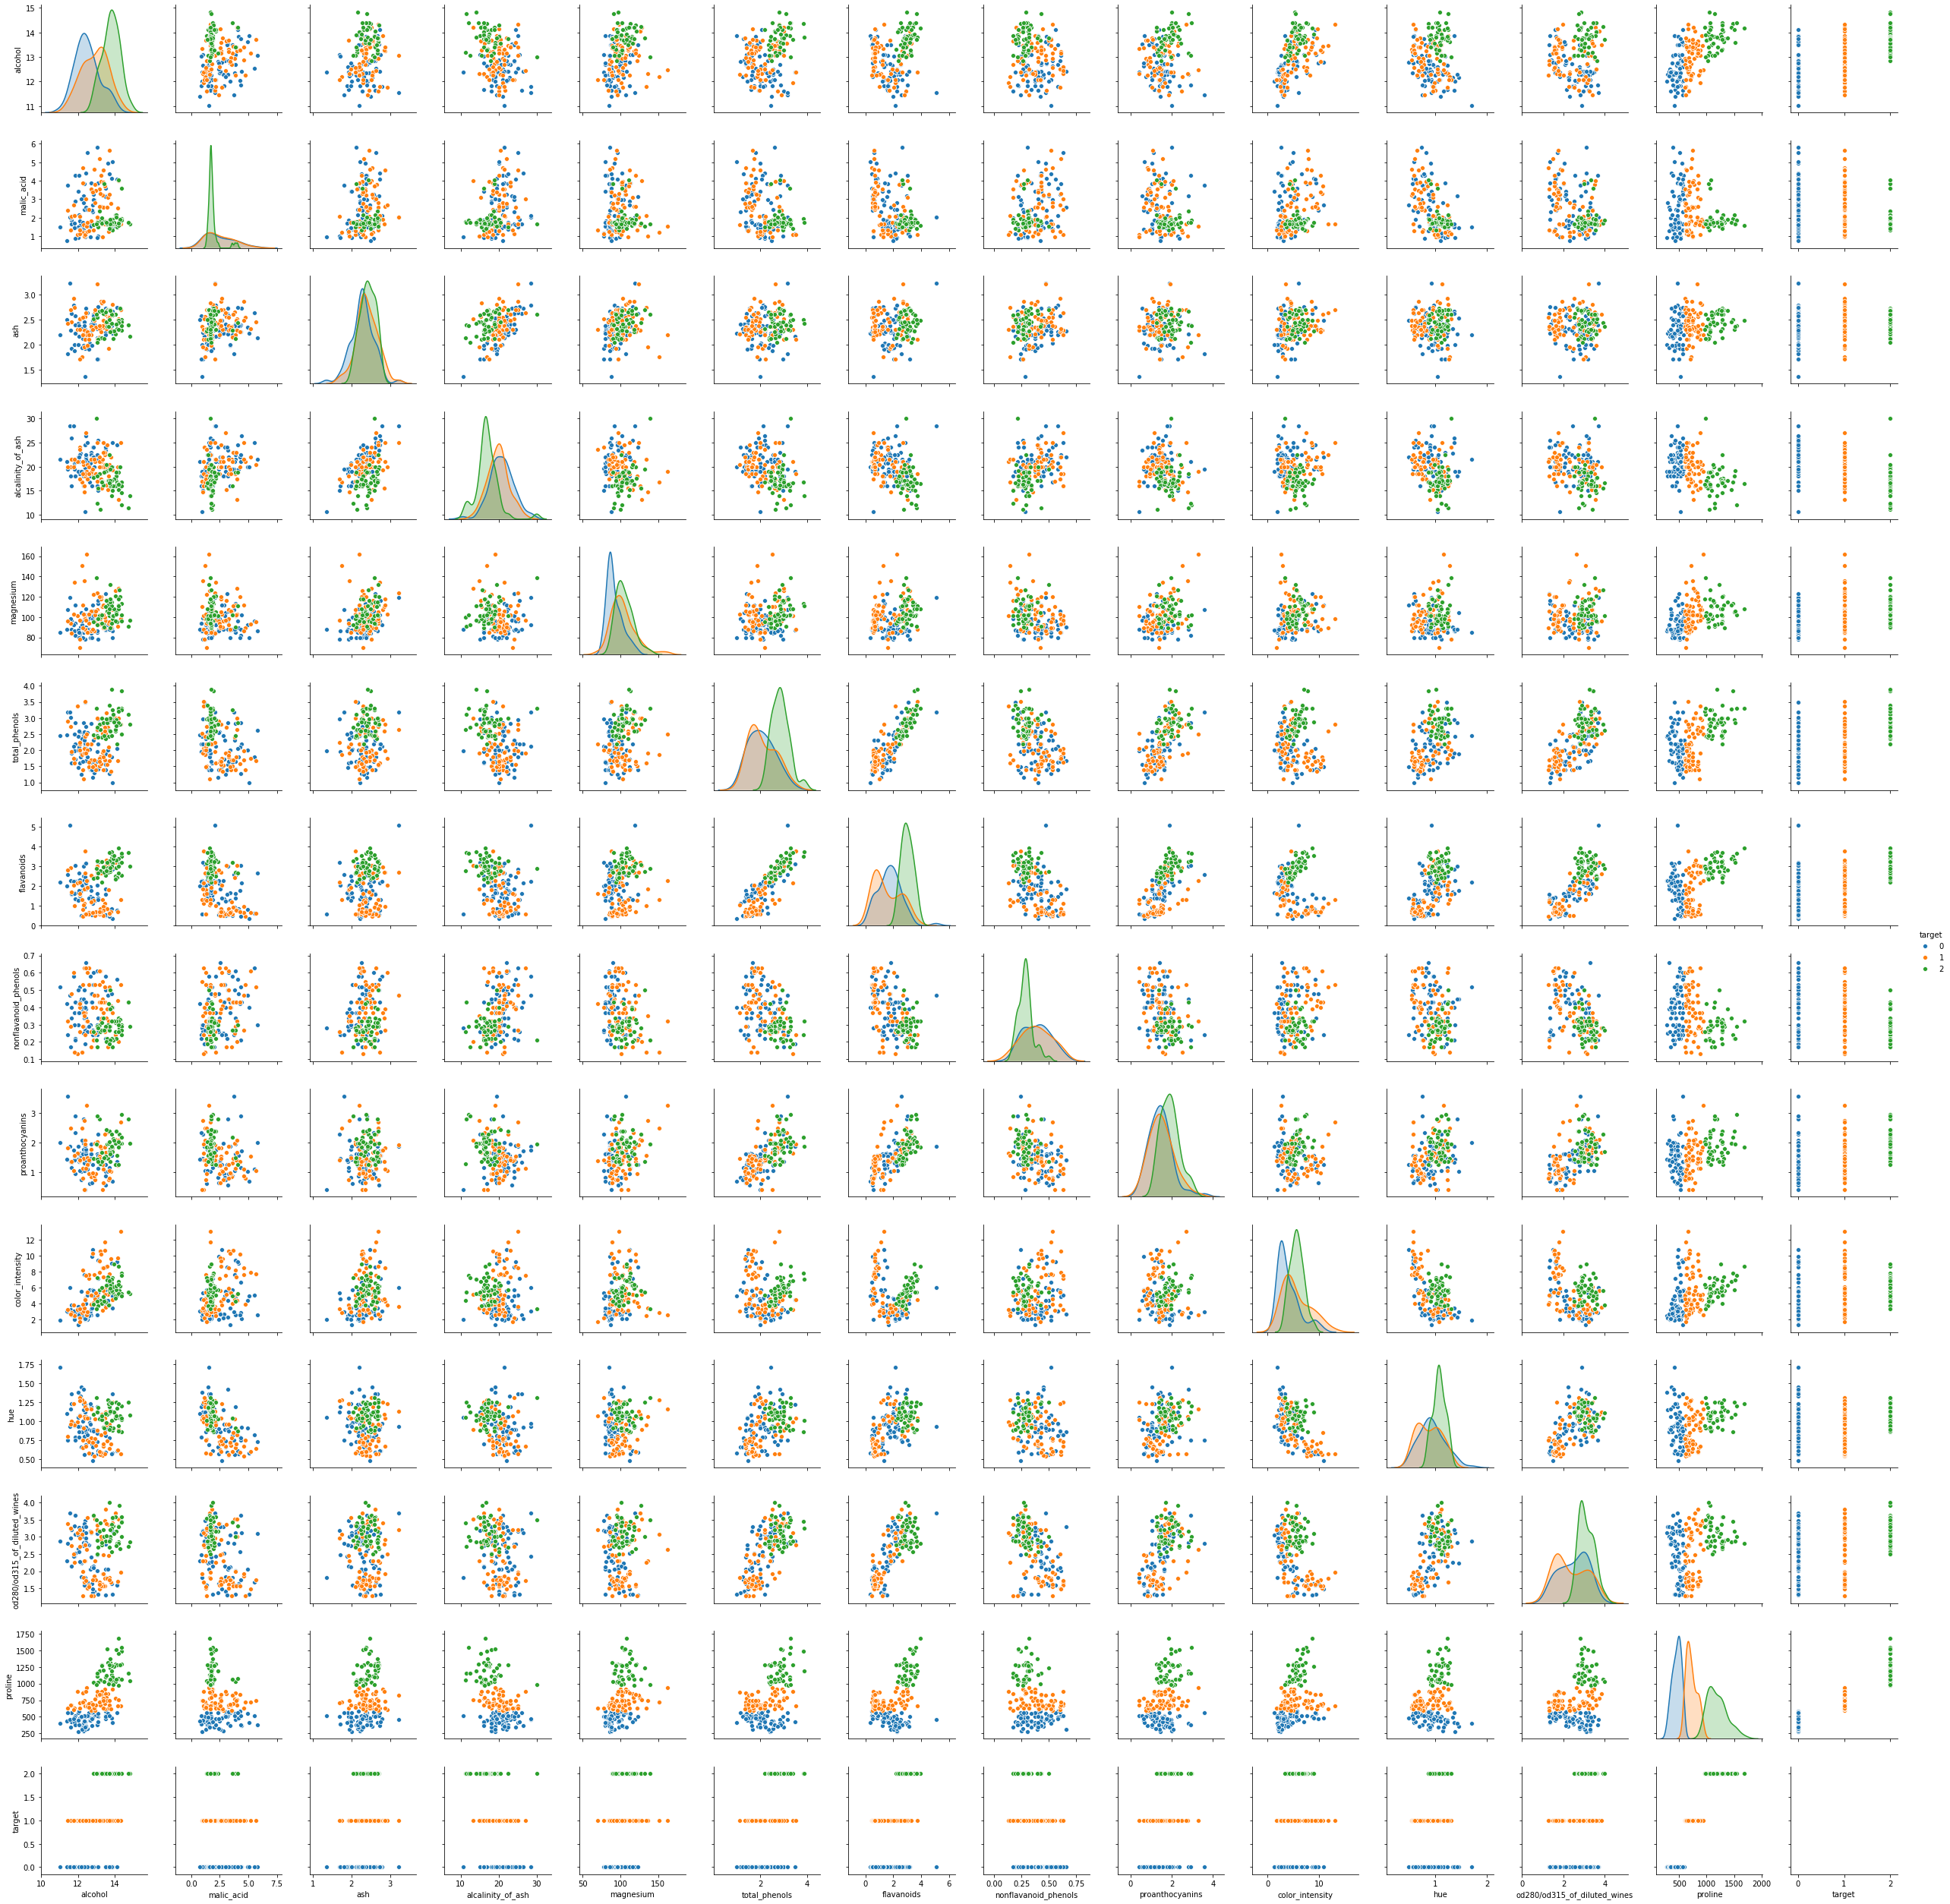

In [53]:
KM = K_MEANS(wine_df, k=len(wine['target_names']), MAX_ITER=100)
KM.RUN(show_images=False)
wine_df['target'] = KM.labels
sns.pairplot(hue='target', data=wine_df)

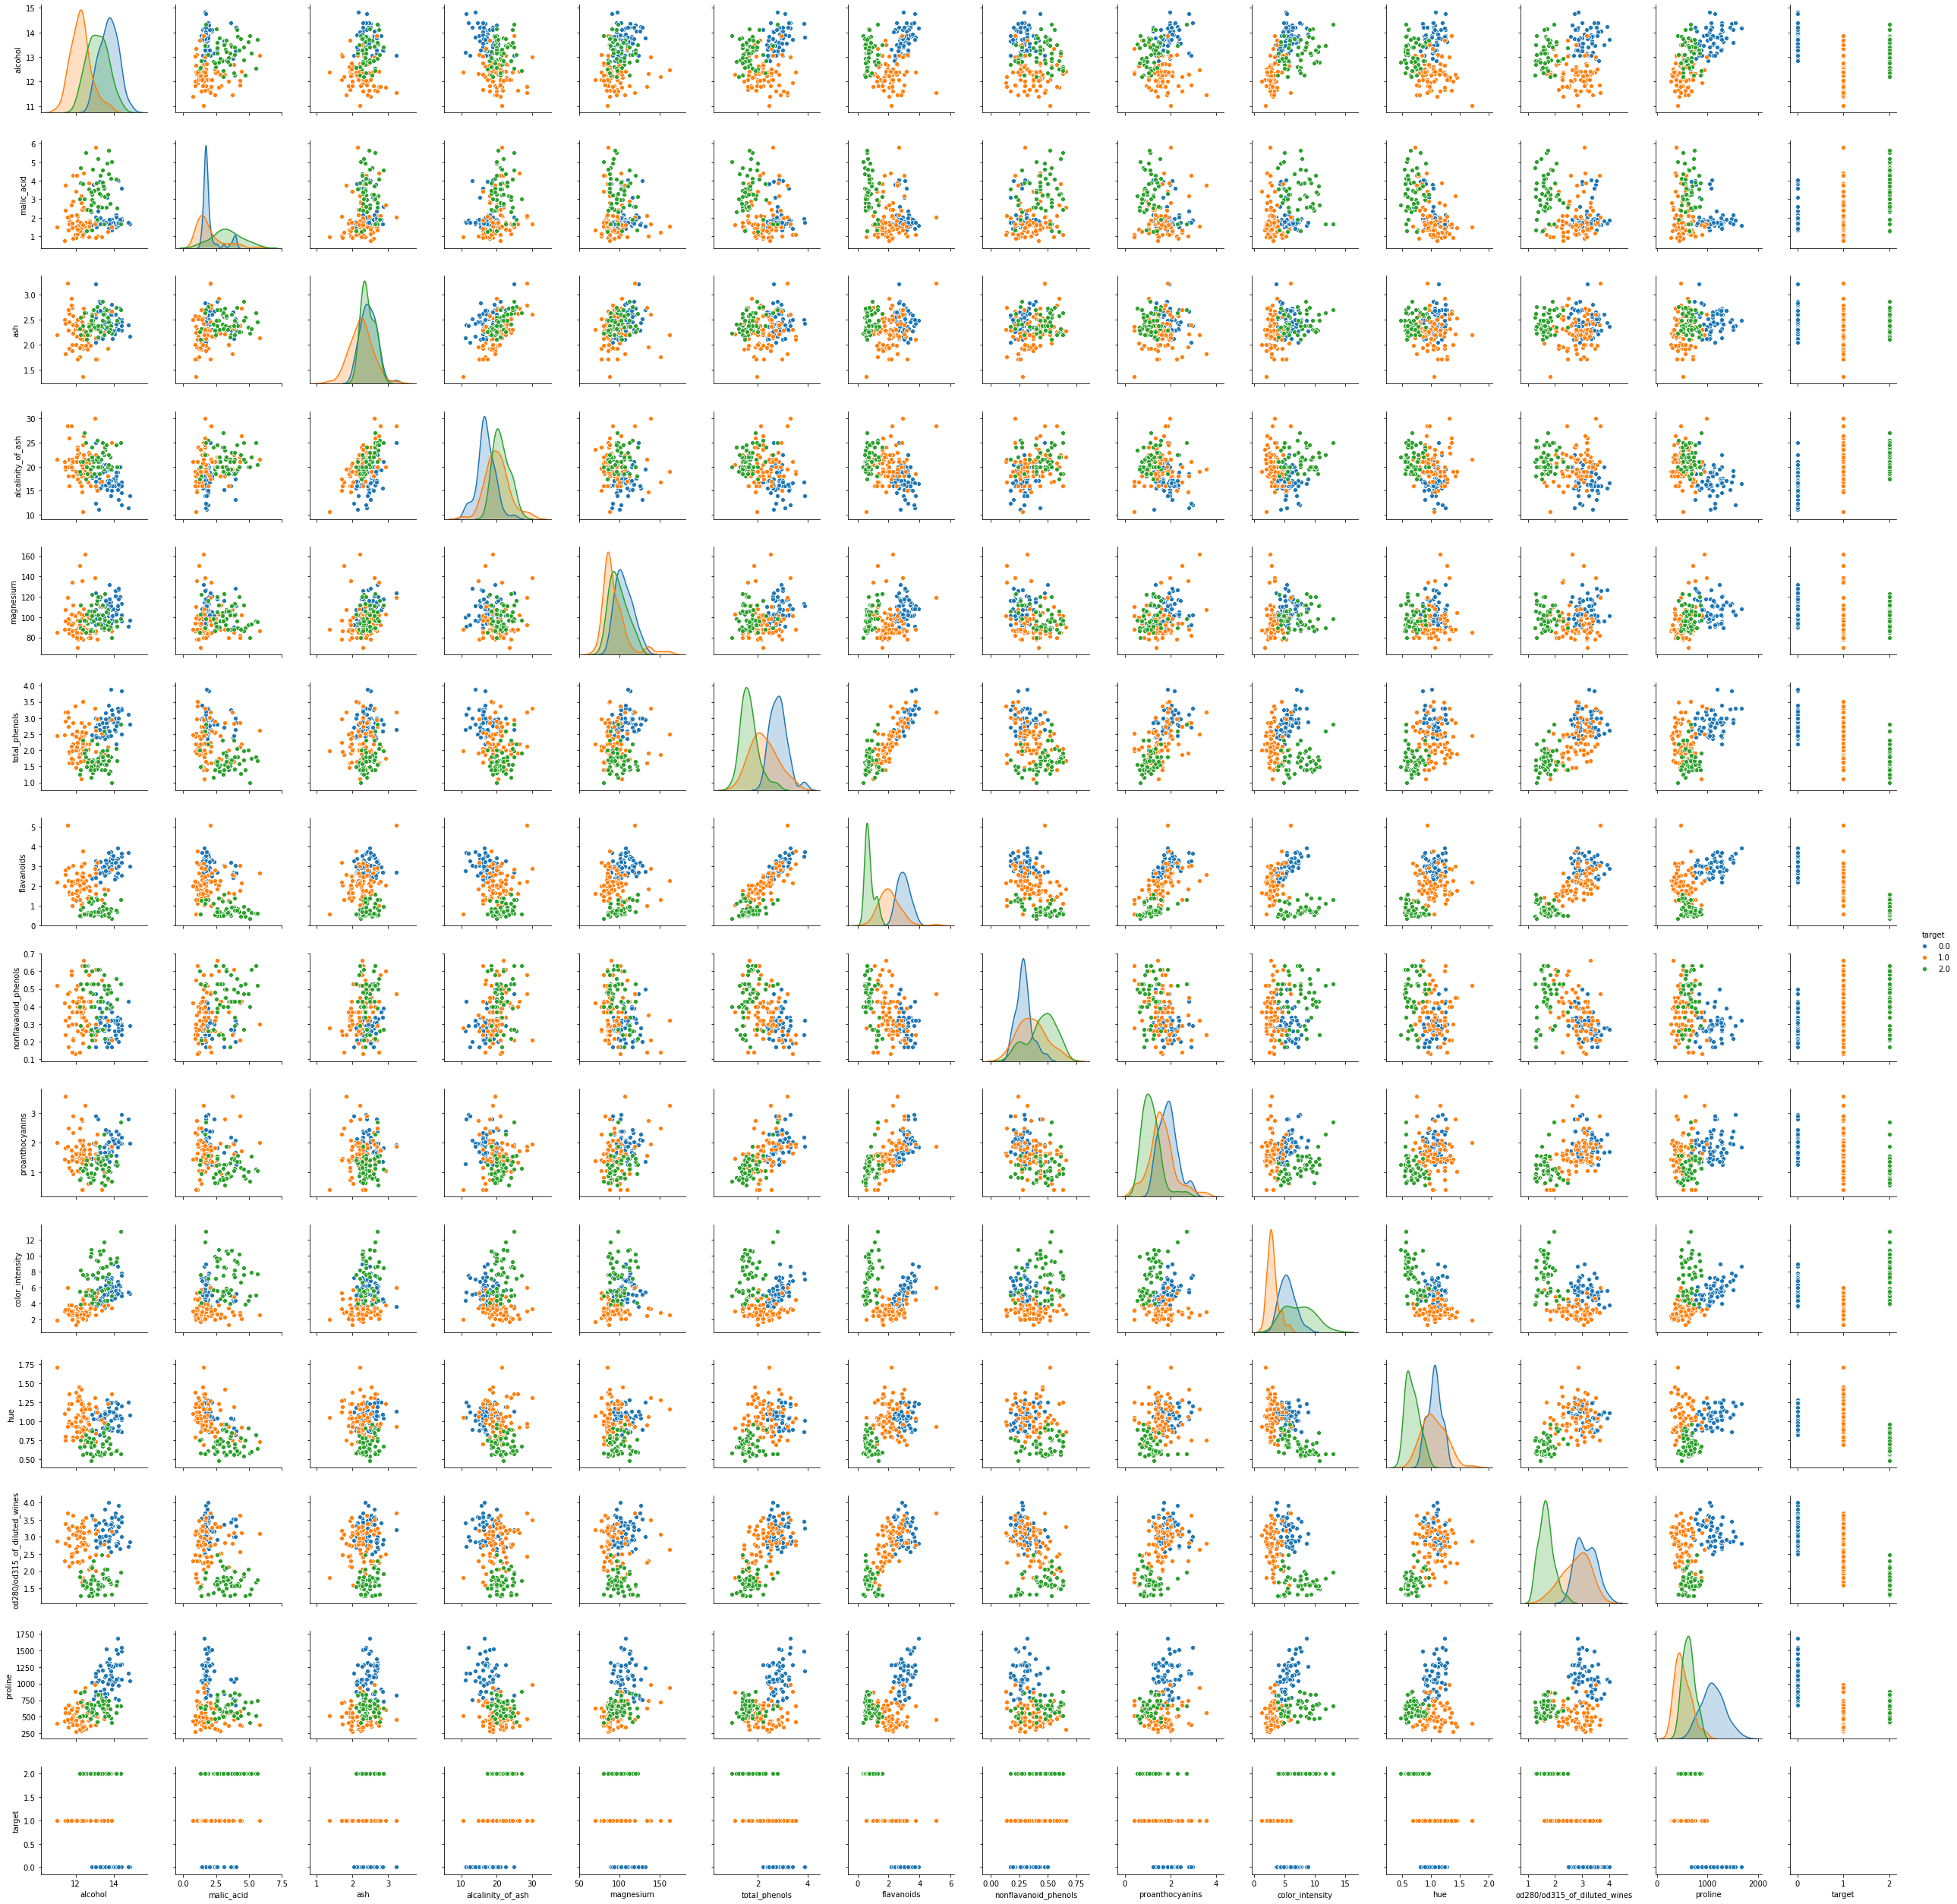

In [54]:
wine_df['target'] = targets
sns.pairplot(hue='target', data=wine_df)

In [80]:
non_relative_err_for_groups = abs(targets.value_counts() - pd.Series(KM.labels).value_counts())
print(f'Error:\n{non_relative_err_for_groups}')

Error:
0.0    10
1.0     9
2.0     1
dtype: int64
